<a href="https://colab.research.google.com/github/LeoVogiatzis/GNN_based_NILM/blob/main/Graph_convolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git


     |████████████████████████████████| 7.9 MB 16.1 MB/s 
     |████████████████████████████████| 3.5 MB 14.3 MB/s 


In [2]:
!pip install git+https://github.com/networkit/networkit.git

  Cloning https://github.com/networkit/networkit.git to /tmp/pip-req-build-l84l0o2x
  Running command git clone -q https://github.com/networkit/networkit.git /tmp/pip-req-build-l84l0o2x
  Running command git submodule update --init --recursive -q
  Created wheel for networkit: filename=networkit-9.1.1-cp37-cp37m-linux_x86_64.whl size=8380317 sha256=864e53fc748f2d2ce622ead8f6af128422a62d023d7a6cdd0f81d06c8a5c0d29
  Stored in directory: /tmp/pip-ephem-wheel-cache-0cmzyf5g/wheels/0f/9e/6a/7bbe7af76ad74c4202f7f790295f53807bff20ae76cb0d16c1
Successfully built networkit


In [3]:
import networkx as nx
import pandas as pd
import torch
import torch_geometric
from torch_geometric.data import Dataset, Data
import numpy as np
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [4]:
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch_geometric.transforms import RandomLinkSplit, RandomNodeSplit
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
import math
import networkit as nk
import time

In [5]:
print(f"Torch version: {torch.__version__}")
print(f"Cuda available: {torch.cuda.is_available()}")
print(f"Torch geometric version: {torch_geometric.__version__}")

Torch version: 1.10.0+cu111
Cuda available: True
Torch geometric version: 2.0.5


In [6]:
import io
from google.colab import files
uploaded = files.upload()

Saving refrigerator_house_2.csv to refrigerator_house_2.csv


In [7]:
class NilmDataset(Dataset):
    def __init__(self, root, filename, window, sigma, test=False, transform=None, pre_transform=None):
        """2
        root = Where the dataset should be stored. This folder is split
        into raw_dir (downloaded dataset) and processed_dir (processed data).
        """
        self.test = test
        self.filename = filename
        self.window = window
        self.sigma = sigma
        super(NilmDataset, self).__init__(root, transform, pre_transform)

    @property
    def raw_file_names(self):
        """ If this file exists in raw_dir, the download is not triggered.
            (The download func. is not implemented here)
        """
        return [self.filename]

    @property
    def processed_file_names(self):
        """ If these files are found in raw_dir, processing is skipped"""
        data = pd.read_csv(self.raw_paths[0]).reset_index()
        if self.test:
            return [f'data_test_{i}.pt' for i in list(data.index)]
        else:
            return [f'data_{i}.pt' for i in list(data.index)]

    def download(self):
        pass

    def process(self):
        idx = 0
        for raw_path in self.raw_paths:
            appliance = pd.read_csv(raw_path, index_col=0).reset_index()
            # appliance = appliance.rolling(10).mean().dropna()
            # appliance[raw_path[9:-4]]
            main_val = appliance[raw_path[9:-4]].values  # get only readings
            data_vec = main_val
            adjacency, drift = self._get_adjacency_info(data_vec)
            edge_indices = self._to_edge_index(adjacency)
            node_feats = self._get_node_features(adjacency)
            # node_feats = np.asarray(drift)
            # node_feats = node_feats.reshape((-1, 1))
            # node_feats = torch.tensor(node_feats, dtype=torch.float)
            # edge_feats = torch.tensor(edge_indices.clone().detach(), dtype=torch.float)
            labels = np.asarray(drift)
            labels = torch.tensor(labels, dtype=torch.int64)

            data = Data(
                x=node_feats,
                edge_index=edge_indices, y=labels
                # , edge_attr=edge_feats
                #  train_mask=[2000], test_mask=[2000]
            )
            X_train, X_test, y_train, y_test = train_test_split(
                pd.Series(np.asarray([i for i in range(data.num_nodes)], dtype=np.int64)),
                pd.Series(np.asarray(labels, dtype=np.float32)), test_size=0.30, random_state=42)

            n_nodes = data.num_nodes

            # create train and test masks for data
            train_mask = torch.zeros(n_nodes, dtype=torch.bool)
            test_mask = torch.zeros(n_nodes, dtype=torch.bool)
            train_mask[X_train.index] = True
            test_mask[X_test.index] = True
            data['train_mask'] = train_mask
            data['test_mask'] = test_mask
            if self.pre_filter is not None and not self.pre_filter(data):
                continue

            if self.pre_transform is not None:
                data = self.pre_transform(data)

            if self.test:
                torch.save(data, os.path.join(self.processed_dir, f'data_test_{idx}.pt'))
            else:
                torch.save(data, os.path.join(self.processed_dir, f'data_{idx}.pt'))
            idx += 1

    def _get_node_features(self, adjacency):
        """
        This will return a matrix / 2d array of the shape
        [Number of Nodes, Node Feature size]

        We could also use networkit module to calculate
        efficiently centrality(ranking) measures
        """

        t0 = time.process_time()
        print("Hello")
        all_node_feats = []
        G = nk.Graph(n=adjacency.shape[1])
        for iy, ix in np.ndindex(adjacency.shape):
            # if (iy != ix): # and (adjacency[iy, ix] != 0):
            G.addEdge(iy, ix)

        bc = nk.centrality.Betweenness(G)
        bc.run()
        t2 = time.process_time() - t0
        print("Time elapsed betweeness: ", t2)
        print(f'The 10 most central nodes according to betweenness are then{bc.ranking()[:10]}')

        close = nk.centrality.Closeness(G, False, nk.centrality.ClosenessVariant.Generalized)
        close.run()
        t3 = time.process_time() - t0
        print("Time elapsed closeness: ", t3)
        print(f'The top 10 nodes based on closeness centrality are{close.ranking()[:10]}')
        # PageRank using L1 norm, and a 100 maximum iterations
        pr = nk.centrality.PageRank(G, 1e-6)
        pr.run()  # the 10 most central nodes
        t4 = time.process_time() - t0
        print("Time elapsed: ", t4)
        print(f'The top 10 nodes based on pagerank measure are{pr.ranking()[:10]}')  # the 10 most central nodes
        ec = nk.centrality.EigenvectorCentrality(G)
        ec.run()
        t5 = time.process_time() - t0
        print("Time elapsed eigenvector: ", t5)
        print(f'The top 10 nodes based on eigenvector centrality are{ec.ranking()[:10]}')
        t1 = time.process_time() - t0
        print("Time elapsed: ", t1)  # CPU seconds elapsed (floating point)
        print('-----------------------Calculation of Centrality Measures is completed-----------------------')
        all_node_feats.extend([[i[1] for i in bc.ranking()[:]], [i[1] for i in pr.ranking()[:]],
                               [i[1] for i in close.ranking()[:]], [i[1] for i in ec.ranking()[:]],
                               # [i[1] for i in btwn.ranking()[:]]
                               ])
        all_node_feats = np.asarray(all_node_feats).transpose()
        # all_node_feats = all_node_feats.reshape((-1, 1))
        return torch.tensor(all_node_feats, dtype=torch.float)

    def _get_adjacency_info(self, data_vec):
        data_aggr = []

        for k in range(0, int(np.floor(len(data_vec) / self.window))):
            data_aggr.append(np.mean(data_vec[k * self.window:((k + 1) * self.window)]))

        if (len(data_vec) % self.window > 0):
            data_aggr.append(np.mean(data_vec[int(np.floor(len(data_vec) / self.window)) * self.window:]))
        delta_p = [np.round(data_aggr[i + 1] - data_aggr[i], 2) for i in range(0, len(data_aggr) - 1)]
        Am = np.zeros((len(delta_p), len(delta_p)))
        for i in range(0, Am.shape[0]):
            for j in range(0, Am.shape[1]):
                Am[i, j] = math.exp(-((delta_p[i] - delta_p[j]) / self.sigma) ** 2)
        Am = np.where(Am != 1, 0, 1)
        print(np.count_nonzero(Am))
        Am[Am!=0]
        print(np.count_nonzero(Am))
        # exit('Test')
        return Am, delta_p

    def _to_edge_index(self, adjacency):

        edge_indices = []
        for i in range(0, adjacency.shape[0]):
            for j in range(i, adjacency.shape[0]):
                if adjacency[i, j] != 0.0:
                    edge_indices += [[i, j], [j, i]]

        edge_indices = torch.tensor(edge_indices)
        edge_indices = edge_indices.t().to(torch.long).view(2, -1)

        return edge_indices

    def len(self):
        return len(self.processed_file_names)

    def get(self, idx):
        """ - Equivalent to __getitem__ in pytorch
            - Is not needed for PyG's InMemoryDataset
        """
        if self.test:
            data = torch.load(os.path.join(self.processed_dir, f'data_-test_{idx}.pt'))
        else:
            data = torch.load(os.path.join(self.processed_dir, f'data_{idx}.pt'))
        return data

In [8]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        torch.manual_seed(42)

        # Initialize the layers
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        # First Message Passing Layer (Transformation)
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)

        # Second Message Passing Layer
        x = self.conv2(x, edge_index)

        return x


def train(model):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    # out = model(dataset.x, dataset.edge_index)  # Perform a single forward pass.
    out = model(train_data.x, train_data.edge_index)
    print(out)
    print(train_data.y)
    # loss = criterion(out[dataset.train_mask], dataset.y[dataset.train_mask])  # Compute the loss solely based on the training nodes.
    loss = criterion(out, train_data.y.view(-1, 1))
    loss.backward(retain_graph=True)  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss


def test(model):
    model.eval()
    out = model(test_data.x, test_data.edge_index)
    test_loss = criterion(out, test_data.y.view(-1, 1))
    # Derive ratio of correct predictions.
    return test_loss

Processing...


2239031
2239031
Hello
Time elapsed betweeness:  81.408408143
The 10 most central nodes according to betweenness are then[(0, 0.0), (1, 0.0), (2, 0.0), (3, 0.0), (4, 0.0), (5, 0.0), (6, 0.0), (7, 0.0), (8, 0.0), (9, 0.0)]
Time elapsed closeness:  117.93257058999998
The top 10 nodes based on closeness centrality are[(0, 1.0), (1, 1.0), (2, 1.0), (3, 1.0), (4, 1.0), (5, 1.0), (6, 1.0), (7, 1.0), (8, 1.0), (9, 1.0)]
Time elapsed:  117.953099211
The top 10 nodes based on pagerank measure are[(0, 0.00039952057530962844), (1, 0.00039952057530962844), (2, 0.00039952057530962844), (3, 0.00039952057530962844), (4, 0.00039952057530962844), (5, 0.00039952057530962844), (6, 0.00039952057530962844), (7, 0.00039952057530962844), (8, 0.00039952057530962844), (9, 0.00039952057530962844)]
Time elapsed eigenvector:  118.009707644
The top 10 nodes based on eigenvector centrality are[(0, 0.01998801078921171), (1, 0.01998801078921171), (2, 0.01998801078921171), (3, 0.01998801078921171), (4, 0.01998801078921

Done!


Data(x=[2503, 4], edge_index=[2, 2241534], y=[2503], train_mask=[2503], test_mask=[2503])
tensor([[0.0000e+00, 3.9952e-04, 1.0000e+00, 1.9988e-02],
        [0.0000e+00, 3.9952e-04, 1.0000e+00, 1.9988e-02],
        [0.0000e+00, 3.9952e-04, 1.0000e+00, 1.9988e-02],
        ...,
        [0.0000e+00, 3.9952e-04, 1.0000e+00, 1.9988e-02],
        [0.0000e+00, 3.9952e-04, 1.0000e+00, 1.9988e-02],
        [0.0000e+00, 3.9952e-04, 1.0000e+00, 1.9988e-02]])
tensor([[0.0000e+00, 3.9952e-04, 1.0000e+00, 1.9988e-02],
        [0.0000e+00, 3.9952e-04, 1.0000e+00, 1.9988e-02],
        [0.0000e+00, 3.9952e-04, 1.0000e+00, 1.9988e-02],
        ...,
        [0.0000e+00, 3.9952e-04, 1.0000e+00, 1.9988e-02],
        [0.0000e+00, 3.9952e-04, 1.0000e+00, 1.9988e-02],
        [0.0000e+00, 3.9952e-04, 1.0000e+00, 1.9988e-02]])
Data(x=[2503, 4], edge_index=[2, 1572578], y=[2503], train_mask=[2503], test_mask=[2503], edge_label=[1572578], edge_label_index=[2, 1572578]) Data(x=[2503, 4], edge_index=[2, 1572578], 

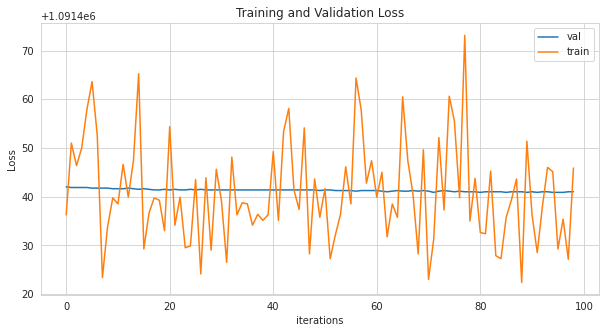

End Pipeline


In [11]:
import matplotlib.pyplot as plt

dataset = NilmDataset(root='data', filename='refrigerator_house_2.csv', window=20, sigma=20)
data = dataset[0]
print(data)

embedding_method = ''
if embedding_method == 'Node2Vec':
    embeddings = node_representations(data)
    data.x = embeddings.data

elif embedding_method == 'AE':
    data = pairwise_auto_encoder(data)

else:
    print(data.x)

data.y = data.y.type(torch.FloatTensor)
print(data.x)

transform = RandomLinkSplit(is_undirected=True)
train_data, val_data, test_data = transform(data)
print(train_data, val_data, test_data)

model = GCN(in_channels=4, hidden_channels=4, out_channels=1)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.MSELoss()
epochs = 20
train_losses = []
val_losses = []
for epoch in range(1, 100):
    loss = train(model)
    # acc = test(model, test_data, criterion)
    test_loss = test(model)
    train_losses.append(loss.item())
    val_losses.append(test_loss.item())
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}')
print(model)
results = model(data.x, data.edge_index)
print(results)
plt.figure(figsize=(10, 5))
plt.title("Training and Validation Loss")
plt.plot(val_losses, label="val")
plt.plot(train_losses, label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()
print('End Pipeline')

In [ ]:
# graph_mains_1.data, graph_mains_1.slices = graph_mains_1.collate([graph_mains_1])

In [ ]:
print(model)

In [ ]:
loader = model.loader(batch_size=128, shuffle=True, num_workers=4)
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)